#  StasBomb에서 데이터를 불러오는 과정

In [31]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [32]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### StatsBombLoader불러오기
Return a dataframe with both teams that participated in a game.

In [33]:
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

In [34]:
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [35]:
competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,4,16,Champions League,Europe,male,2018/2019
1,1,16,Champions League,Europe,male,2017/2018
2,2,16,Champions League,Europe,male,2016/2017
3,27,16,Champions League,Europe,male,2015/2016
4,26,16,Champions League,Europe,male,2014/2015
5,25,16,Champions League,Europe,male,2013/2014
6,24,16,Champions League,Europe,male,2012/2013
7,23,16,Champions League,Europe,male,2011/2012
8,22,16,Champions League,Europe,male,2010/2011
9,21,16,Champions League,Europe,male,2009/2010


# La Liga데이터를 활용

- train : 2004/2005 ~ 2018/2019
- valid : 2019/2020
- test  : 2020/2021

In [36]:
train_competitions = competitions[(competitions['season_name'] <= '2019') & (competitions['competition_name'].isin(['La Liga']))]
valid_competitions = competitions[(competitions['season_name'] == '2019/2020') & (competitions['competition_name'].isin(['La Liga']))]
test_competitions = competitions[(competitions['season_name'] == '2020/2021') & (competitions['competition_name'].isin(['La Liga']))]

In [37]:
print(train_competitions.shape)
print(valid_competitions.shape)
print(test_competitions.shape)

(15, 6)
(1, 6)
(1, 6)


### game_id = 3773689는 score와 concede가 둘 다 true인 데이터가 존재해서 그냥 지워버림

In [39]:
#이건 이름 부를 대 어떤 competitions인지 애매하니까 쓰는거임
data_name = ['train_competitions', 'valid_competitions', 'test_competitions']


for i, selected_competitions in enumerate([train_competitions, valid_competitions, test_competitions]):
    games = pd.concat([
        SBL.games(row.competition_id, row.season_id)
        for row in selected_competitions.itertuples()
    ])
    
    games_verbose = tqdm.tqdm(list(games.itertuples()), desc=data_name[i]+"Loading soccer game data")
    teams, players = [], []
    
    actions = {}
    for game in games_verbose:
        #해당 game_id는 오류가 존재하므로 제외시킴
        if game.game_id == 3773689:
            print(game_id)
            continue
        
        # load data
        teams.append(SBL.teams(game.game_id))
        players.append(SBL.players(game.game_id))
        events = SBL.events(game.game_id)
        # convert data
        actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)
        
    teams = pd.concat(teams).drop_duplicates(subset="team_id")
    players = pd.concat(players)

    datafolder = "./data-fifa/La Liga"

    # Create data folder if it doesn't exist
    if not os.path.exists(datafolder):
        os.mkdir(datafolder)
        print(f"Directory {datafolder} created.")

    spadl_h5 = os.path.join(datafolder, f"spadl-statsbomb_{data_name[i]}.h5")

    # Store all spadl data in h5-file
    with pd.HDFStore(spadl_h5) as spadlstore:
        spadlstore["competitions"] = selected_competitions
        spadlstore["games"] = games
        spadlstore["teams"] = teams
        spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
        spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
        for game_id in actions.keys():
            if game.game_id == 3773689:
                print(game_id)
                continue
            spadlstore[f"actions/game_{game_id}"] = actions[game_id]

test_competitionsLoading soccer game data:  94%|█████████▍| 33/35 [00:42<00:02,  1.30s/it]

303473


test_competitionsLoading soccer game data: 100%|██████████| 35/35 [00:43<00:00,  1.26s/it]


In [43]:
#이건 이름 부를 대 어떤 competitions인지 애매하니까 쓰는거임
data_name = ['train_competitions', 'valid_competitions', 'test_competitions']


for i, selected_competitions in enumerate([train_competitions, valid_competitions, test_competitions]):
    if i!=2:
        continue
    games = pd.concat([
        SBL.games(row.competition_id, row.season_id)
        for row in selected_competitions.itertuples()
    ])
    
    games_verbose = tqdm.tqdm(list(games.itertuples()), desc=data_name[i]+"Loading soccer game data")
    teams, players = [], []
    
    actions = {}
    for game in games_verbose:
        #해당 game_id는 오류가 존재하므로 제외시킴
        if game.game_id == 3773689:
            print(game_id)
            continue
        
        # load data
        teams.append(SBL.teams(game.game_id))
        players.append(SBL.players(game.game_id))
        events = SBL.events(game.game_id)
        # convert data
        actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)
        
    teams = pd.concat(teams).drop_duplicates(subset="team_id")
    players = pd.concat(players)

    datafolder = "./data-fifa/La Liga"

    # Create data folder if it doesn't exist
    if not os.path.exists(datafolder):
        os.mkdir(datafolder)
        print(f"Directory {datafolder} created.")

    spadl_h5 = os.path.join(datafolder, f"spadl-statsbomb_{data_name[i]}.h5")

    # Store all spadl data in h5-file
    with pd.HDFStore(spadl_h5) as spadlstore:
        spadlstore["competitions"] = selected_competitions
        spadlstore["games"] = games
        spadlstore["teams"] = teams
        spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
        spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
        for game_id in actions.keys():
            if game.game_id == 3773689:
                print(game_id)
                continue
            spadlstore[f"actions/game_{game_id}"] = actions[game_id]

test_competitionsLoading soccer game data:  94%|█████████▍| 33/35 [00:19<00:01,  1.69it/s]

3773477


test_competitionsLoading soccer game data: 100%|██████████| 35/35 [00:20<00:00,  1.71it/s]


In [44]:
len(actions.keys())

34

In [47]:
actions

{3773457:       game_id                     original_event_id  period_id  time_seconds   
 0     3773457  daac9c8d-95b6-4e42-8cfa-b05779fd7755          1           0.0  \
 1     3773457  8bab938f-718c-4cb1-8f79-48ac1fd2f6fd          1           1.0   
 2     3773457  f29cb427-30ed-4011-89cb-9df2fcee58fb          1           2.0   
 3     3773457  257003ba-4790-4bba-bce1-39c95757ed84          1           5.0   
 4     3773457  a8dd57bd-0a84-4cb2-a536-06975a6ff914          1           6.0   
 ...       ...                                   ...        ...           ...   
 2425  3773457  a1a0bc00-97dd-4824-9fe8-f2f1bf67ae3f          2        2862.0   
 2426  3773457  76090519-ebe0-46de-99cc-9d5b3e88cc91          2        2866.0   
 2427  3773457  73a242b1-cb99-4ef9-9779-61917f59e24e          2        2899.0   
 2428  3773457  41fc6fb5-832e-49eb-bdf5-a05633affb5e          2        2904.0   
 2429  3773457  7ded24f3-2c88-4ff3-ab4e-14d625ad6188          2        2905.0   
 
       team_id  p

In [45]:
spadl_h5

'./data-fifa/La Liga\\spadl-statsbomb_test_competitions.h5'

In [46]:
test_games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(test_games))

nb of games: 35


In [22]:
spadl2_h5 = os.path.join(datafolder, "spadl-statsbomb_test_competitions.h5")
features2_h5 = os.path.join(datafolder, "features_test.h5")
labels2_h5 = os.path.join(datafolder, "labels_test.h5")

In [17]:
for key in actions.keys():
    if key==3773689:
        print(key)

In [11]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    #Select korea vs germany game at World Cup
    game = games
    
    for i in range(len(game.game_id)):
        
        game_id = game.game_id.values[i]
    
        actions = (
            spadlstore[f"actions/game_{game_id}"]
            .merge(spadl.actiontypes_df(), how="left")
            .merge(spadl.results_df(), how="left")
            .merge(spadl.bodyparts_df(), how="left")
            .merge(spadlstore["players"], how="left")
            .merge(spadlstore["teams"], how="left")
        )
        
        # a = pd.concat([a,actions])
#use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']

In [12]:
actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,3773477,a39b9c13-9a01-4452-b6fa-d5058ead67bf,1,0.0,218,6880.0,52.058824,33.655696,56.382353,35.549367,0,1,5,0,pass,success,foot_right,Antonio Sanabria,Real Betis
1,3773477,cc81f927-dda5-4ead-9a0f-38072ea0c563,1,1.0,218,6673.0,56.382353,35.549367,49.676471,37.959494,21,1,0,1,dribble,success,foot,Sergio Canales,Real Betis
2,3773477,571103bd-adb0-4f9a-b591-e9fbd6ee80f6,1,3.0,218,6673.0,49.676471,37.959494,36.088235,64.470886,0,0,4,2,pass,fail,foot_left,Sergio Canales,Real Betis
3,3773477,e62ef626-4bbd-4efa-a923-6bc939de5ab0,1,5.0,217,5211.0,35.294118,65.245570,35.294118,65.245570,10,1,0,3,interception,success,foot,Jordi Alba,Barcelona
4,3773477,301b4005-4f81-4d3c-ac21-b9a59ddad5cc,1,5.0,217,5211.0,35.294118,65.245570,45.352941,64.298734,21,1,0,4,dribble,success,foot,Jordi Alba,Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,3773477,4a798266-43d7-4c9a-91d5-276cc5228b69,2,2972.0,218,6851.0,68.823529,64.556962,37.676471,57.068354,0,1,5,2235,pass,success,foot_right,Aitor Ruibal,Real Betis
2236,3773477,edd38889-aaed-45b8-8ad4-16718a477d66,2,2974.0,217,6826.0,42.000000,58.101266,42.000000,58.101266,8,1,0,2236,foul,success,foot,Clément Lenglet,Barcelona
2237,3773477,6a5e2ead-5a23-4cc7-8f17-e2cc14e98a53,2,3002.0,218,41083.0,48.970588,62.577215,6.529412,34.688608,3,0,4,2237,freekick_crossed,fail,foot_left,Rodri,Real Betis
2238,3773477,09fcb776-16cd-41fc-82f5-387115a4f97e,2,3006.0,217,20055.0,5.735294,35.463291,6.970588,31.503797,21,1,0,2238,dribble,success,foot,Marc-André ter Stegen,Barcelona


2021-05-16 18:30:00 Barcelona 1-2 Celta Vigo 84'


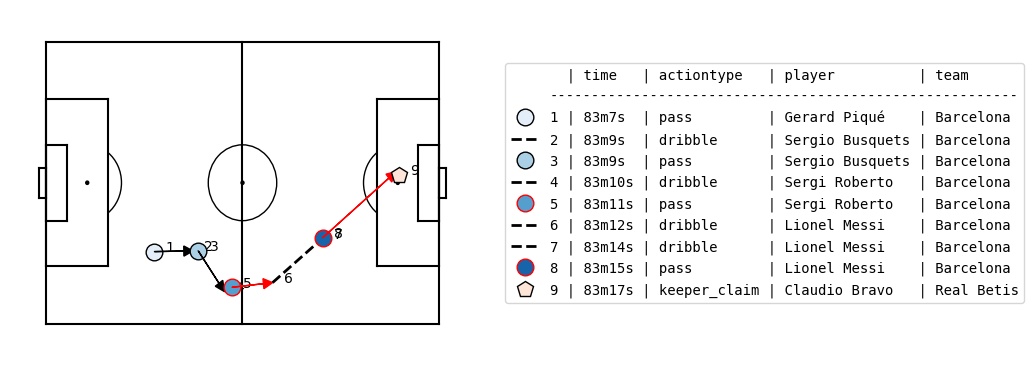

In [13]:
import matplotsoccer

# Select the 5 actions preceding the 2-0
shot = 2046
a = actions[shot-4:shot+5].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)